In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import re
import h5py
from six.moves import range

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline

In [15]:
from scipy.optimize import curve_fit

In [2]:
def compute_purity_via_row_norm(arr):
    pur_arr = np.zeros_like(arr)
    pur_arr_err = np.zeros_like(arr)
    for i in range(np.shape(arr)[0]):
        npass = arr[i, :]
        ntotal = arr.sum(axis=1)[i]
        epsilon = npass / ntotal
        pur_arr[i, :] = epsilon
        pur_arr_err[i, :] = np.sqrt(epsilon * (1 - epsilon) / ntotal)
        
    return pur_arr, pur_arr_err

In [3]:
def compute_effic_via_col_norm(arr):
    eff_arr = np.zeros_like(arr)
    eff_arr_err = np.zeros_like(arr)
    for i in range(np.shape(arr)[0]):
        npass = arr[:, i]
        ntotal = arr.sum(axis=0)[i]
        epsilon = npass / ntotal
        eff_arr[:, i] = epsilon
        eff_arr_err[i, :] = np.sqrt(epsilon * (1 - epsilon) / ntotal)
        
    return eff_arr, eff_arr_err

In [4]:
def make_plots_raw(arr, plot_type, colormap='Reds'):
    """
    plots and text for confusion matrices
    """
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(1, 2)

    def make_title_string(title, logscale):
        title = r'Log$_{10}$ ' + title if logscale else title
        return title
    
    def make_subplot(ax, show_arr, colormap, title):
        im = ax.imshow(show_arr, cmap=plt.get_cmap(colormap), interpolation='nearest', origin='lower')
        cbar = plt.colorbar(im, fraction=0.04)
        plt.title(title)
        plt.xlabel('True z-segment')
        plt.ylabel('Reconstructed z-segment')
        
    # linear plots
    ax = plt.subplot(gs[0])
    show_arr = arr
    make_subplot(ax, show_arr, colormap, make_title_string('Confustion matrix', False))

    # log plots
    ax = plt.subplot(gs[1])
    show_arr = np.log10(arr * 100.0)
    make_subplot(ax, show_arr, colormap, make_title_string('Confustion matrix', True))
    
    fig.savefig('confusion_matrices_raw_{}.pdf'.format(plot_type), bbox_inches='tight')

In [8]:
def make_plots_rowcolnormonly(
    arr, plot_type, top_title='Purity', bottom_title='Efficiency', colormap='Reds', 
    print_arrays=False, print_targets=True
):
    """
    plots and text for confusion matrices
    """
    target_plane_codes = {9: 1, 18: 2, 27: 3, 44: 4, 49: 5}
    fig = plt.figure(figsize=(16,16))
    gs = plt.GridSpec(2, 2)

    # purity calc
    pur_arr, pur_arr_err = compute_purity_via_row_norm(arr)
    eff_arr, eff_arr_err = compute_effic_via_col_norm(arr)

    if print_arrays:
        print("purity (row-normalized diagonal values)")
        for i in range(pur_arr.shape[0]):
            print('segment {:2d}: purity = {:.3f}'.format(i, pur_arr[i, i]))
        print("efficiency (column-normalized diagonal values)")
        for i in range(eff_arr.shape[0]):
            print('segment {:2d}: efficiency = {:.3f}'.format(i, eff_arr[i, i]))
    
    if print_targets:
        print("purity (row-normalized diagonal values)")
        for i in target_plane_codes.keys():
            print('target {:2d}: purity = {:.3f} +/- {:.3f} (stat)'.format(
                target_plane_codes[i], pur_arr[i, i], pur_arr_err[i, i]
            ))
        print("efficiency (column-normalized diagonal values)")
        for i in target_plane_codes.keys():
            print('target {:2d}: efficiency = {:.3f} +/- {:.3f} (stat)'.format(
                target_plane_codes[i], eff_arr[i, i], eff_arr_err[i, i]
            ))

    
    def make_title_string(title_base, title_mod, logscale):
        title = title_base.format(title_mod)
        title = r'Log$_{10}$ ' + title if logscale else title
        return title
    
    def make_subplot(ax, show_arr, colormap, title):
        im = ax.imshow(show_arr, cmap=plt.get_cmap(colormap), interpolation='nearest', origin='lower')
        cbar = plt.colorbar(im, fraction=0.04)
        plt.title(title)
        plt.xlabel('True z-segment')
        plt.ylabel('Reconstructed z-segment')
        
    # purity linear plots
    ax = plt.subplot(gs[0])
    show_arr = pur_arr
    make_subplot(ax, show_arr, colormap, make_title_string('Purity (row normalized)\n{}', top_title, False))

    # purity log plots
    ax = plt.subplot(gs[1])
    show_arr = np.log10(pur_arr * 100.0)
    make_subplot(ax, show_arr, colormap, make_title_string('Purity (row normalized)\n{}', top_title, True))
    
    # efficiency linear plots
    ax = plt.subplot(gs[2])
    show_arr = eff_arr
    make_subplot(ax, show_arr, colormap, make_title_string('Efficiency (column normalized)\n{}', bottom_title, False))

    # efficiency log plots
    ax = plt.subplot(gs[3])
    show_arr = np.log10(eff_arr * 100.0)
    make_subplot(ax, show_arr, colormap, make_title_string('Efficiency (column normalized)\n{}', bottom_title, True))

    fig.savefig('confusion_matrices_rowcolnorm_{}.pdf'.format(plot_type), bbox_inches='tight')
    
    return pur_arr, eff_arr

In [9]:
npy_name = '/Users/perdue/Documents/MINERvA/AI/minerva_tf/models/173/collab_mtg_173'

t_type = 'confusion_matrix_trainG_testB'
npy_name += '/' + t_type + '.npy'

arr = np.load(npy_name)
print(arr.shape)

plot_type_base = t_type + '_'
plot_type = plot_type_base + str(arr.shape[0])

(173, 173)


/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys
/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10


purity (row-normalized diagonal values)
target  1: purity = 0.829 +/- 0.001 (stat)
target  2: purity = 0.872 +/- 0.001 (stat)
target  3: purity = 0.885 +/- 0.001 (stat)
target  4: purity = 0.780 +/- 0.002 (stat)
target  5: purity = 0.821 +/- 0.002 (stat)
efficiency (column-normalized diagonal values)
target  1: efficiency = 0.969 +/- 0.001 (stat)
target  2: efficiency = 0.953 +/- 0.001 (stat)
target  3: efficiency = 0.901 +/- 0.001 (stat)
target  4: efficiency = 0.898 +/- 0.002 (stat)
target  5: efficiency = 0.920 +/- 0.001 (stat)


/Users/perdue/miniconda2/envs/py2mnv_pda/lib/python2.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log10


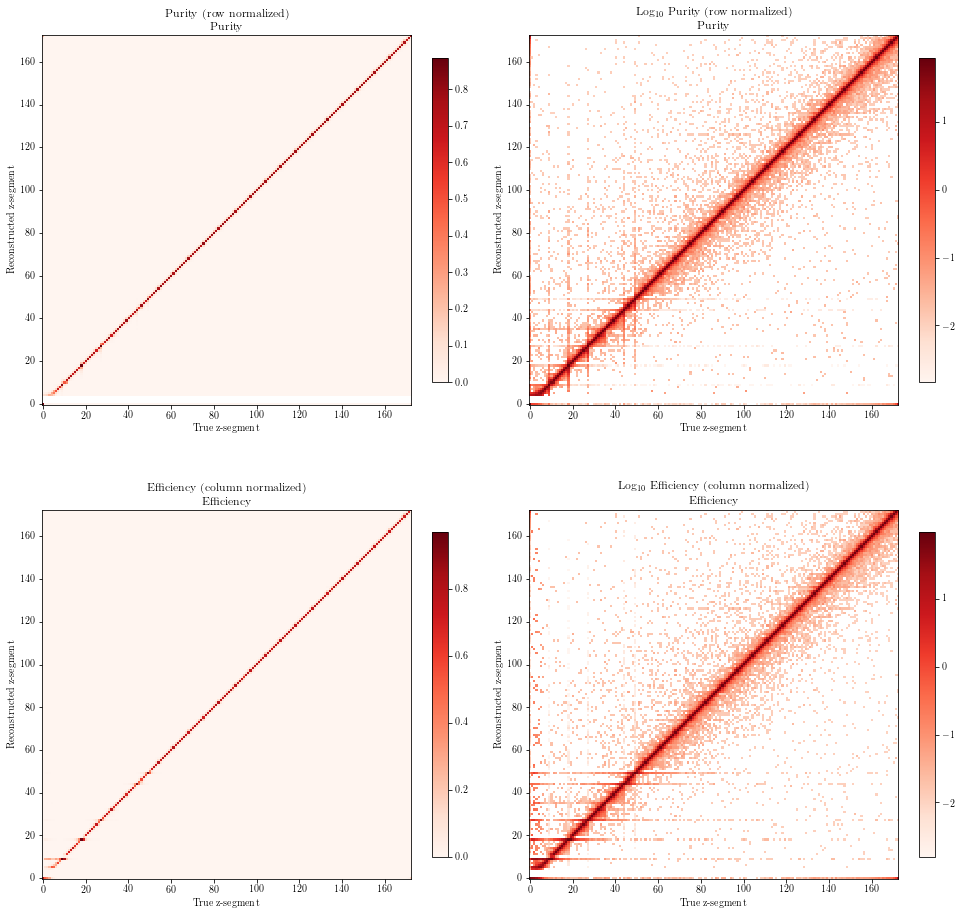

In [85]:
pur_arr, eff_arr = make_plots_rowcolnormonly(arr, plot_type)

In [87]:
def bias_fn(x, mu, sig):
    return 1.0/(sig * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu)/(sig))**2)

def bias_fn(x, m, b, norm, mu, sig):
    return m * x + b + norm/(sig * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu)/(sig))**2)

def bias_fn(x, a, b, norm, mu, sig):
    return a * np.exp(-b * x) + norm/(sig * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu)/(sig))**2)

def bias_fn(x, m, b, mu, sig):
    """normal plus linear"""
    return m * x + b + 1.0/(sig * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu)/(sig))**2)

def bias_fn(x, m, b, x0, gamma):
    """cauchy plus linear"""
    return m * x + b + 1/(np.pi * gamma) * (gamma**2)/((x - x0)**2 + gamma**2)

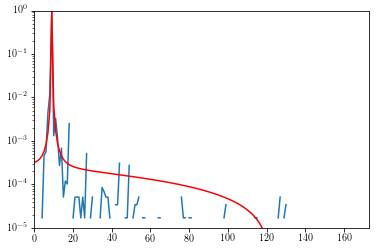

[ -2.07490049e-06   2.53779291e-04   9.07354857e+00   1.73911335e-02]
[[  1.43309784e-12  -1.26767424e-10   9.52094358e-10   4.79197812e-10]
 [ -1.26767424e-10   1.46263305e-08  -1.13154312e-07  -5.69506443e-08]
 [  9.52094358e-10  -1.13154312e-07   1.02888768e-05   5.15543459e-06]
 [  4.79197812e-10  -5.69506443e-08   5.15543459e-06   2.58346226e-06]]
[  1.19712065e-06   1.20939367e-04   3.20762791e-03   1.60731523e-03]


In [89]:
targ1_colnorm = eff_arr[:,9]
bounds = ([0, 0, 7, 0], [1, 1, 11, 1])
bounds = None
np.sum(targ1_colnorm)
if bounds:
    popt, pcov = curve_fit(bias_fn, np.arange(173), targ1_colnorm, bounds=bounds)
else:
    popt, pcov = curve_fit(bias_fn, np.arange(173), targ1_colnorm)
plt.semilogy(np.arange(173), targ1_colnorm)
plt.semilogy(np.arange(173), bias_fn(np.arange(173), *popt), 'r-', label='fit')
plt.axis((0, 173, 0.00001, 1))
plt.show()
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))

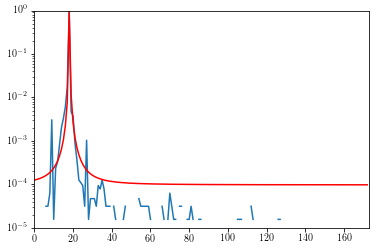

18
[  1.24453094e-15   9.77581608e-05   1.80941026e+01   2.90264026e-02]
[[  2.50723058e-12  -2.21058436e-10   1.04668325e-09   7.20095535e-10]
 [ -2.21058436e-10   2.55674957e-08  -1.28916949e-07  -8.86891210e-08]
 [  1.04668325e-09  -1.28916949e-07   9.21529048e-06   6.28486471e-06]
 [  7.20095535e-10  -8.86891210e-08   6.28486471e-06   4.28771215e-06]]
[  1.58342369e-06   1.59898392e-04   3.03566969e-03   2.07067915e-03]


In [90]:
targ2_colnorm = eff_arr[:,18]
bounds = ([0, 0, 16, 0], [1, 1, 20, 1])
popt, pcov = curve_fit(bias_fn, np.arange(173), targ2_colnorm, bounds=bounds)
plt.semilogy(np.arange(173), targ2_colnorm)
plt.semilogy(np.arange(173), bias_fn(np.arange(173), *popt), 'r-', label='fit')
plt.axis((0, 173, 0.00001, 1))
plt.show()
print(np.argmax(targ2_colnorm))
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))

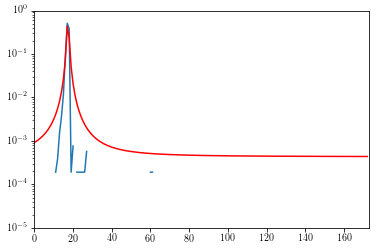

17
[  1.22083304e-19   4.33520219e-04   1.73508162e+01   4.63645543e-01]
[[  4.60664493e-10  -4.11742032e-08  -1.54317109e-07   4.86782943e-07]
 [ -4.11742032e-08   4.77552658e-06   1.89325816e-05  -5.97936433e-05]
 [ -1.54317109e-07   1.89325816e-05   6.51641376e-04  -1.66123768e-03]
 [  4.86782943e-07  -5.97936433e-05  -1.66123768e-03   5.74450424e-03]]
[  2.14630961e-05   2.18529783e-03   2.55272673e-02   7.57925078e-02]


In [91]:
targ2_colnorm_minus1 = eff_arr[:,17]
bounds = ([0, 0, 15, 0], [1, 1, 19, 1])
popt, pcov = curve_fit(bias_fn, np.arange(173), targ2_colnorm_minus1, bounds=bounds)
plt.semilogy(np.arange(173), targ2_colnorm_minus1)
plt.semilogy(np.arange(173), bias_fn(np.arange(173), *popt), 'r-', label='fit')
plt.axis((0, 173, 0.00001, 1))
plt.show()
print(np.argmax(targ2_colnorm_minus1))
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))

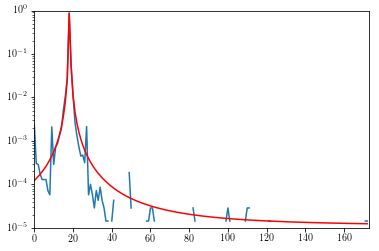

18
[  3.83022826e-11   1.09067151e-05   1.81701954e+01   1.16681073e-01]
[[  4.66360603e-13  -4.10467987e-11   4.13611601e-11   1.19302264e-10]
 [ -4.10467987e-11   4.74569664e-09  -5.09926949e-09  -1.47012371e-08]
 [  4.13611601e-11  -5.09926949e-09   1.05137128e-07   2.64202028e-07]
 [  1.19302264e-10  -1.47012371e-08   2.64202028e-07   6.90019685e-07]]
[  6.82905999e-07   6.88890168e-05   3.24248559e-04   8.30674235e-04]


In [92]:
targ2_rownorm = pur_arr[18,:]
bounds = ([0, 0, 16, 0], [1, 1, 20, 1])
popt, pcov = curve_fit(bias_fn, np.arange(173), targ2_rownorm, bounds=bounds)
plt.semilogy(np.arange(173), targ2_rownorm)
plt.semilogy(np.arange(173), bias_fn(np.arange(173), *popt), 'r-', label='fit')
plt.axis((0, 173, 0.00001, 1))
plt.show()
print(np.argmax(targ2_rownorm))
print(popt)
print(pcov)
print(np.sqrt(np.diag(pcov)))